## Trial by trial decoding analysis

In [13]:
%reload_ext autoreload
%autoreload 2

In [9]:
import spyglass as nd
import pandas as pd
import os
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import multiprocessing

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection

import spyglass.spikesorting as ss
from spyglass.spikesorting import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
#from spyglass.decoding.clusterless import (UnitMarks,
#                                           UnitMarkParameters,UnitMarksIndicatorSelection,
#                                          UnitMarksIndicator)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection
from spyglass.common.common_position import IntervalLinearizedPosition


# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import (TrialChoice,
                                   TrialChoiceReplay,
                                   RippleTimes,
                                   Decode,get_linearization_map,
                                   find_ripple_times,mua_thresholder,
                                   segment_ripples,sort_replays,
                                   classify_ripples,classify_ripple_content,
                                   load_everything,plot_decode_spiking,
                                  )

[2023-06-13 10:13:08,947][INFO]: Connecting shijiegu@lmf-db.cin.ucsf.edu:3306
13-Jun-23 10:13:08 Connecting shijiegu@lmf-db.cin.ucsf.edu:3306


OperationalError: (2003, "Can't connect to MySQL server on 'lmf-db.cin.ucsf.edu' ([Errno 113] No route to host)")

In [6]:
# the only cell to be edited
nwb_file_name = 'eliot20221021.nwb'
#epoch_num=4

In [7]:
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
TrialChoice() & {'nwb_file_name':nwb_copy_file_name}

NameError: name 'get_nwb_copy_filename' is not defined

In [17]:
def interpolate_to_new_time(df, new_time, upsampling_interpolation_method='linear'):
    old_time = df.index
    new_index = pd.Index(np.unique(np.concatenate(
        (old_time, new_time))), name='time')
    return (df
            .reindex(index=new_index)
            .interpolate(method=upsampling_interpolation_method)
            .reindex(index=new_time))

In [18]:
def find_ripple_classify_decode(log_df,
                                node_location,linear_position_df,
                                ripple_times,decode,recordings,neural_ts, #spiking data
                                ripple_nwb,ripple_timestamps,
                                mua,mua_time,mua_threshold,
                                exampledir,
                                t):

    # for each trial, find important times
    t_home=log_df.loc[t,'timestamp_H']
    t_outer=log_df.loc[t,'timestamp_O']
    if t+1<len(log_df):
        t_end=log_df.loc[t+1,'timestamp_H']
    else:
        t_end=log_df.loc[t,'timestamp_H']+10
    
    ''' HOME '''
    # find times close to home well
    time_slice = slice(t_home,t_outer)
    current_location = node_location['home']
    position_subset=linear_position_df.loc[time_slice]
    close_ind=np.argwhere(np.abs(position_subset.linear_position.values-
                                 current_location)<5).ravel()
    try:
        t_home_start=position_subset.index[close_ind[0]]
        t_home_end=position_subset.index[close_ind[-1]]
    except:
        print('trial failed:',t)
        print('position_subset',position_subset)
        return [],[],[],[],[],[]
    
    # Home well ripple
    ripple_H_=find_ripple_times(ripple_times,t_home_start,t_home_end)
    
    # remove those replays without mua above the mean
    print(mua_threshold)
    ripple_H_=mua_thresholder(ripple_H_,mua,mua_time,mua_threshold)
    
    # segment ripple
    # unsegmented is "ripple_H_", segmented is called "cont_ripple_H" or "frag_ripple_H"
    cont_ripple_H,frag_ripple_H=segment_ripples(decode,ripple_H_)
    
    # classify into arms, Home well replay, only for continuous replays
    cont_replay_H=classify_ripples(decode,cont_ripple_H)
    
    assert len(cont_ripple_H)==len(cont_replay_H)
    
    # sort
    ripple_H,replay_H=sort_replays(cont_ripple_H,frag_ripple_H,cont_replay_H)
    
    '''plot each ripple at home, meanwhile find peak'''
    peak_H=[]
    
    for i in range(np.shape(ripple_H_)[0]):
        peaks=plot_decode_spiking(ripple_H_[i],    #ripple start and end time
                            linear_position_df,
                            decode, #decode result
                            recordings,neural_ts, #spiking data
                            ripple_nwb,ripple_timestamps,#ripple
                            offset=1, #2 second window
                            savefolder=exampledir,
                            title='classified as: arm '+str(replay_H[i]),
                            savename='trial'+str(t)+'_home_'+str(i+1))
        peak_H.append(peaks)
    
    
    ''' OUTER '''
    # find times close to outer
    time_slice = slice(t_home,t_end)
    current_location = node_location['well'+str(int(log_df.loc[t,'OuterWellIndex']))]
    position_subset=linear_position_df.loc[time_slice]
    close_ind=np.argwhere(np.abs(position_subset.linear_position.values-
                                 current_location)<5).ravel()
    try:
        t_outer_start=position_subset.index[close_ind[0]]
        t_outer_end=position_subset.index[close_ind[-1]]
    except:
        print('trial failed:',t)
        print('position_subset',position_subset)
        return [],[],[],[],[],[]
    
    
    # Outer well replay
    ripple_O_=find_ripple_times(ripple_times,t_outer_start,t_outer_end)
    
    # remove those replays without mua above the mean
    ripple_O_=mua_thresholder(ripple_O_,mua,mua_time,mua_threshold)
    
    # segment ripple
    cont_ripple_O,frag_ripple_O=segment_ripples(decode,ripple_O_)
    
    # classify ripple
    cont_replay_O=classify_ripples(decode,cont_ripple_O)
    
    assert len(cont_ripple_O)==len(cont_replay_O)
    
    # sort
    ripple_O,replay_O=sort_replays(cont_ripple_O,frag_ripple_O,cont_replay_O)
    
    '''plot each ripple at outer well'''
    peak_O=[]
    for i in range(np.shape(ripple_O_)[0]):
        peaks=plot_decode_spiking(ripple_O_[i],    #ripple start and end time
                            linear_position_df,
                            decode, #decode result
                            recordings,neural_ts, #spiking data
                            ripple_nwb,ripple_timestamps,#ripple
                            offset=1, #2 second window
                            savefolder=exampledir,
                            title='classified as: arm '+str(replay_O[i]),
                            savename='trial'+str(t)+'_outer_'+str(i+1))
        peak_O.append(peaks)
        
    return ripple_H,replay_H,peak_H,ripple_O,replay_O,peak_O

In [19]:
def add_replay(epoch_num):
    # RUN THIS CELL AFTER CHANGING FILE
    
    # 1. Load state script
    key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num}
    log=(TrialChoice & key).fetch1('choice_reward')
    epoch_name=(TrialChoice & key).fetch1('epoch_name')
    epoch_pos_name='pos '+str(int(epoch_name[:2])-1)+' valid times'
    print('epoch name',epoch_name)
    log_df=pd.DataFrame(log)

    # 1.5 Pre-make result directory:
    decoding_path=(Decode() & {'nwb_file_name':nwb_copy_file_name}).fetch('posterior')[0]
    exampledir=os.path.join(os.path.split(decoding_path)[0],nwb_file_name,epoch_name)
    isExist = os.path.exists(exampledir)
    if not isExist:
        os.makedirs(exampledir)

    # 2. Pre-expand result: Augment choice_reward table to be choice_reward_replay
    log_df_replay=log_df.copy()
    log_df_replay.insert(5,'ripple_H',[[] for i in range(len(log_df))]) #hold ripple times
    log_df_replay.insert(6,'ripple_O',[[] for i in range(len(log_df))])
    log_df_replay.insert(7,'replay_H',[[] for i in range(len(log_df))]) #hold decoded replay
    log_df_replay.insert(8,'ripple_peak_H',[[] for i in range(len(log_df))]) #hold decoded replay
    log_df_replay.insert(9,'replay_O',[[] for i in range(len(log_df))])
    log_df_replay.insert(10,'ripple_peak_O',[[] for i in range(len(log_df))]) #hold decoded replay

    # 3. linear map
    linear_map,node_location=get_linearization_map()

    # 4. load position, decoding, ripple times, mua threshold
    (linear_position_df,decode,ripple_nwb,
     ripple_timestamps,ripple_times,
     recordings,neural_ts,
     mua,mua_time)=load_everything(nwb_copy_file_name,
                    epoch_name,
                    epoch_pos_name)

    # 5. find immobility times position
    position_info_param_name = 'default'
    position_valid_times = (IntervalList & {'nwb_file_name': nwb_copy_file_name,
                                            'interval_list_name': epoch_pos_name}).fetch1('valid_times')

    position_info = (IntervalPositionInfo() & {'nwb_file_name': nwb_copy_file_name,
                     'interval_list_name': epoch_pos_name,
                     'position_info_param_name': position_info_param_name}).fetch1_dataframe()

    position_info = pd.concat(
        [position_info.loc[slice(valid_time[0], valid_time[1])]
         for valid_time in position_valid_times], axis=0)

    head_speed=pd.DataFrame(position_info['head_speed'])

    position_info_upsample = interpolate_to_new_time(head_speed, mua_time)

    imobility_ind=position_info_upsample['head_speed']<=5
    mua_threshold=np.mean(mua[imobility_ind])


    # find legal trials
    rewardNum=np.array(log_df.rewardNum)
    legal_trials=(np.argwhere(np.logical_and(rewardNum[1:]>=1,rewardNum[:-1]>=1))+1).ravel()

    trial_ind=np.array(log_df.index)
    
    '''
    here the actual work gets done
    '''
    #numWorker=30
    #print('num of worker:',numWorker)
    #with multiprocessing.Pool(numWorker) as p:
    #    results=p.map(find_ripple_classify_decode,legal_trials)
    for t in legal_trials:
        print('trial',t)
        results=find_ripple_classify_decode(log_df,
                                            node_location,linear_position_df,
                                            ripple_times,decode,recordings,neural_ts, #spiking data
                                            ripple_nwb,ripple_timestamps,
                                            mua,mua_time,mua_threshold,
                                            exampledir,
                                            t)
        

        # add to the choice_reward_replay
        log_df_replay.at[t, 'ripple_H']=results[0]
        log_df_replay.at[t, 'ripple_O']=results[3]
    
        log_df_replay.at[t, 'replay_H']= results[1]
        log_df_replay.at[t, 'replay_O']= results[4]
    
        #log_df_replay.at[t, 'ripple_peak_H']= results[2]
        #log_df_replay.at[t, 'ripple_peak_O']= results[5]
    print('Done parsing. Insert into Spyglass')
    log_df_replay_subset=log_df_replay.loc[legal_trials,:].copy()
    
    # insert into Spyglass
    key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num,'choice_reward_replay':log_df_replay_subset.to_dict()}
    TrialChoiceReplay().make(key,replace=True)

In [17]:
results=find_ripple_classify_decode(log_df,
                                    node_location,linear_position_df,
                                    ripple_times,decode,recordings,neural_ts, #spiking data
                                    ripple_nwb,ripple_timestamps,
                                    mua,mua_time,mua_threshold,
                                    exampledir,
                                    26)

NameError: name 'log_df' is not defined

In [ ]:
add_replay(8)

epoch name 08_Seq2Session4
trial 1
35.77927127755043


/home/shijiegu/Documents/spyglass/src/spyglass/shijiegu/Analysis_SGU.py:428: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(6, 1, figsize=(25, 25), sharex=True,


trial 2
35.77927127755043
trial 3
35.77927127755043
trial 4
35.77927127755043
trial 5
35.77927127755043
trial 6
35.77927127755043
trial 7
35.77927127755043
trial 8
35.77927127755043
trial 9
35.77927127755043
trial 10
35.77927127755043
trial 11
35.77927127755043
trial 12
35.77927127755043
trial 13
35.77927127755043
trial 14
35.77927127755043
trial 15
35.77927127755043
trial 16
35.77927127755043
trial 17
35.77927127755043
trial 18
35.77927127755043
trial 19
35.77927127755043
trial 20
35.77927127755043
trial 21
35.77927127755043
trial 22
35.77927127755043
trial 23
35.77927127755043
trial 24
35.77927127755043
trial 25
35.77927127755043
trial 26
35.77927127755043
trial 27
35.77927127755043
trial 28
35.77927127755043
trial 29
35.77927127755043
trial 30
35.77927127755043
trial 31
35.77927127755043
trial 32
35.77927127755043
trial 33
35.77927127755043
trial 34
35.77927127755043
trial 35
35.77927127755043
trial 36
35.77927127755043
trial 37
35.77927127755043
trial 38
35.77927127755043
trial 39


### for whole day

In [20]:
all_epochs=list((TrialChoice() & {'nwb_file_name':nwb_copy_file_name}).fetch('epoch'))
all_epochs

[2, 4, 6, 8]

In [16]:
%%capture stored_output
with multiprocessing.Pool(3) as p:
    p.map(add_replay,all_epochs)

[2023-06-09 10:36:32,416][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-06-09 10:36:32,416][WARNING]: MySQL server has gone away. Reconnecting to the server.
[2023-06-09 10:36:32,416][WARNING]: MySQL server has gone away. Reconnecting to the server.
09-Jun-23 10:36:32 MySQL server has gone away. Reconnecting to the server.
09-Jun-23 10:36:32 MySQL server has gone away. Reconnecting to the server.
09-Jun-23 10:36:32 MySQL server has gone away. Reconnecting to the server.


KeyboardInterrupt: 

In [17]:
stored_output.show()

In [11]:
print('here')

here


In [ ]:
%%capture stored_output
add_replay(2)
add_replay(4)
add_replay(6)
add_replay(8)

In [ ]:
add_replay(6)

epoch name 06_Seq2Session3


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

trial 1
35.04443089428752
trial 2
35.04443089428752


/home/shijiegu/Documents/spyglass/src/spyglass/shijiegu/Analysis_SGU.py:428: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(6, 1, figsize=(25, 25), sharex=True,


trial 3
35.04443089428752
trial 4
35.04443089428752
trial 5
35.04443089428752
trial 6
35.04443089428752
trial 7
35.04443089428752
trial 8
35.04443089428752
trial 9
35.04443089428752
trial 10
35.04443089428752
trial 11
35.04443089428752
trial 12
35.04443089428752
trial 13
35.04443089428752
trial 14
35.04443089428752
trial 15
35.04443089428752
trial 16
35.04443089428752
trial 17
35.04443089428752
trial 18
35.04443089428752
trial 19
35.04443089428752
trial 20
35.04443089428752
trial 21
35.04443089428752
trial 22
35.04443089428752
trial 23
35.04443089428752
trial 24
35.04443089428752
trial 25
35.04443089428752
trial 26
35.04443089428752


In [208]:
add_replay(10)
add_replay(12)

epoch name 10_Seq2Session5
trial 1
trial failed: 1
position_subset               linear_position  track_segment_id  projected_x_position  \
time                                                                    
1.650492e+09              NaN                 0                   NaN   
1.650492e+09              NaN                 0                   NaN   
1.650492e+09              NaN                 0                   NaN   
1.650492e+09              NaN                 0                   NaN   
1.650492e+09              NaN                 0                   NaN   
...                       ...               ...                   ...   
1.650492e+09       583.187638                 8                257.75   
1.650492e+09       583.187638                 8                257.75   
1.650492e+09       583.187638                 8                257.75   
1.650492e+09       583.187638                 8                257.75   
1.650492e+09       583.187638                 8          

In [144]:
    epoch_num=8
    
    # 1. Load state script
    key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num}
    log=(TrialChoice & key).fetch1('choice_reward')
    epoch_name=(TrialChoice & key).fetch1('epoch_name')
    epoch_pos_name='pos '+str(int(epoch_name[:2])-1)+' valid times'
    print('epoch name',epoch_name)
    log_df=pd.DataFrame(log)

epoch name 08_Seq2Session3


In [145]:
log_df.loc[66,:]

timestamp_H       1.650062e+09
Home              1.000000e+00
timestamp_O       1.650062e+09
OuterWellIndex    2.000000e+00
rewardNum         1.000000e+00
Name: 66, dtype: float64

In [148]:
log_df.loc[66,:].timestamp_H

1650062026.5339143

In [149]:
linear_position_df = (IntervalLinearizedPosition() &
                      {'nwb_file_name': nwb_copy_file_name,
                       'interval_list_name': epoch_pos_name,
                       'position_info_param_name': 'default_decoding'}
                         ).fetch1_dataframe()

In [160]:
    t=68
    
    # for each trial, find important times
    t_home=log_df.loc[t,'timestamp_H']
    t_outer=log_df.loc[t,'timestamp_O']
    if t+1<len(log_df):
        t_end=log_df.loc[t+1,'timestamp_H']
    else:
        t_end=log_df.loc[t,'timestamp_H']+10
    
    ''' HOME '''
    # find times close to home well
    time_slice = slice(t_home,t_outer)
    current_location = node_location['home']
    position_subset=linear_position_df.loc[time_slice]
    close_ind=np.argwhere(np.abs(position_subset.linear_position.values-
                                 current_location)<5).ravel()

In [161]:
position_subset.index[0]

1650062082.9242132

In [162]:
position_subset

,linear_position,track_segment_id,projected_x_position,projected_y_position
time,,,,
1.650062e+09,238.028962,6,138.679149,104.692813
1.650062e+09,238.028769,6,138.679305,104.692924
1.650062e+09,238.028577,6,138.679462,104.693035
1.650062e+09,238.028385,6,138.679619,104.693146
1.650062e+09,238.028193,6,138.679776,104.693257
...,...,...,...,...
1.650062e+09,236.523876,6,139.907675,105.562298
1.650062e+09,236.523684,6,139.907832,105.562409
1.650062e+09,236.523492,6,139.907989,105.562520


In [124]:
    epoch_num=6
    
    # 1. Load state script
    key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num}
    log=(TrialChoice & key).fetch1('choice_reward')
    epoch_name=(TrialChoice & key).fetch1('epoch_name')
    epoch_pos_name='pos '+str(int(epoch_name[:2])-1)+' valid times'
    print('epoch name',epoch_name)
    log_df=pd.DataFrame(log)

    # 1.5 Pre-make result directory:
    decoding_path=(Decode() & {'nwb_file_name':nwb_copy_file_name}).fetch('posterior')[0]
    exampledir=os.path.join(os.path.split(decoding_path)[0],nwb_file_name,epoch_name)
    isExist = os.path.exists(exampledir)
    if not isExist:
        os.makedirs(exampledir)

    # 2. Pre-expand result: Augment choice_reward table to be choice_reward_replay
    log_df_replay=log_df.copy()
    log_df_replay.insert(5,'ripple_H',[[] for i in range(len(log_df))]) #hold ripple times
    log_df_replay.insert(6,'ripple_O',[[] for i in range(len(log_df))])
    log_df_replay.insert(7,'replay_H',[[] for i in range(len(log_df))]) #hold decoded replay
    log_df_replay.insert(8,'ripple_peak_H',[[] for i in range(len(log_df))]) #hold decoded replay
    log_df_replay.insert(9,'replay_O',[[] for i in range(len(log_df))])
    log_df_replay.insert(10,'ripple_peak_O',[[] for i in range(len(log_df))]) #hold decoded replay

    # 3. linear map
    linear_map,node_location=get_linearization_map()

    # 4. load position, decoding, ripple times, mua threshold
    (linear_position_df,decode,ripple_nwb,
     ripple_timestamps,ripple_times,
     recordings,neural_ts,
     mua,mua_time)=load_everything(nwb_copy_file_name,
                    epoch_name,
                    epoch_pos_name)
    


epoch name 06_Seq2Session2


In [78]:
(IntervalList & {'nwb_file_name': nwb_copy_file_name,'interval_list_name': epoch_pos_name}).fetch1('valid_times')[0]

array([1.65030769e+09, 1.65030907e+09])

In [43]:
    position_info = (IntervalPositionInfo() & {'nwb_file_name': nwb_copy_file_name,
                     'interval_list_name': epoch_pos_name,
                     'position_info_param_name': 'default'}).fetch1_dataframe()

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/molly20220418_HJ00MG2JQ9.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)


In [53]:
log_df.loc[60].timestamp_H

1650309043.9077516

In [61]:
log_df.loc[61].timestamp_H

1650309062.4968216

In [73]:
log_df.loc[82].timestamp_H

1650309696.696209

In [81]:
ripple_timestamps[0]

1650307630.6322308

In [80]:
position_info.index[0]

1650307689.4366117

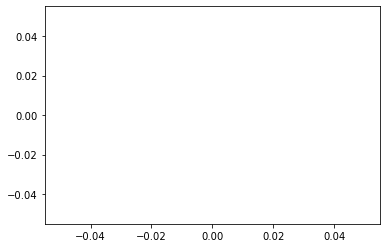

In [58]:
plt.plot(linear_position_df.loc[linear_position_df.index>1650309121,'linear_position'])

In [ ]:
add_replay(10)

epoch name 10_Seq2Session5


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8

In [12]:
TrialChoiceReplay() & {'nwb_file_name':nwb_copy_file_name}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),"epoch_name session name, get from IntervalList","choice_reward_replay pandas dataframe, choice, reward, ripple time, replays"
eliot20221019_.nwb,2,02_Seq2Session1,=BLOB=
eliot20221019_.nwb,4,04_Seq2Session2,=BLOB=
eliot20221019_.nwb,6,06_Seq2Session3,=BLOB=
eliot20221019_.nwb,8,08_Seq2Session4,=BLOB=
eliot20221019_.nwb,10,10_Seq2Session5,=BLOB=


In [6]:
choice_reward_replay=(TrialChoiceReplay() & {'nwb_file_name':nwb_copy_file_name}).fetch1('choice_reward_replay')

NameError: name 'nwb_copy_file_name' is not defined

In [14]:
pd.DataFrame(choice_reward_replay)

,timestamp_H,Home,timestamp_O,OuterWellIndex,rewardNum,ripple_H,ripple_O,replay_H,ripple_peak_H,replay_O,ripple_peak_O,current,future_H,future_O,past,past_reward
1,1.665960e+09,1.0,1.665960e+09,4.0,1.0,"[[[1665960472.3327117, 1665960472.3887117]], [...","[[[1665960489.1487033, 1665960489.2387033]], [...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...",[],"[[4], [4], [4]]",[],4.0,4.0,2.0,NaN,NaN
2,1.665961e+09,1.0,1.665961e+09,2.0,1.0,"[[[1665960502.1666968, 1665960502.3486967]], [...","[[[1665960522.7886863, 1665960522.8526862]]]","[[0], [3.0, nan], [0], [0], [0], [nan, 0.0], [...",[],[[2]],[],2.0,2.0,3.0,4.0,NaN
3,1.665961e+09,1.0,1.665961e+09,3.0,2.0,"[[[1665960531.086682, 1665960531.1386821]], [[...","[[[1665960558.978668, 1665960559.218668]], [[1...","[[0], [0], [0], [0.0, nan], [nan], [4.0, nan, ...",[],"[[3], [3], [3], [3], [3], [3]]",[],3.0,3.0,1.0,2.0,NaN
4,1.665961e+09,1.0,1.665961e+09,1.0,1.0,"[[[1665960574.83666, 1665960574.9686599]], [[1...","[[[1665960593.5166507, 1665960593.7186506]], [...","[[0], [0], [2], [0], [0], [0], [0], [4.0, nan]...",[],"[[1], [1], [1], [1], [1]]",[],1.0,1.0,4.0,3.0,3.0
5,1.665961e+09,1.0,1.665961e+09,4.0,2.0,"[[[1665960607.6626434, 1665960607.6906433], [1...","[[[1665960626.454634, 1665960626.516634]], [[1...","[[0.0, 5.0, nan, 5.0, nan, 0.0], [0], [0], [0....",[],"[[4], [4], [4], [nan], [4], [nan, 4.0], [4], [...",[],4.0,4.0,2.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,1.665962e+09,1.0,1.665962e+09,4.0,2.0,[],"[[[1665962258.2678096, 1665962258.3858097]], [...",[],[],"[[4], [4], [4.0, nan, 2.0], [4], [4.0, nan], [...",[],4.0,4.0,2.0,2.0,3.0
77,1.665962e+09,1.0,1.665962e+09,2.0,2.0,"[[[1665962277.7098, 1665962277.7937999]]]",[],[[0]],[],[],[],2.0,2.0,3.0,4.0,4.0
78,1.665962e+09,1.0,1.665962e+09,3.0,1.0,"[[[1665962300.4957883, 1665962300.5517883]], [...","[[[1665962311.293783, 1665962311.343783]]]","[[0], [nan], [0], [2.0, nan]]",[],[[3]],[],3.0,3.0,1.0,2.0,2.0
79,1.665962e+09,1.0,1.665962e+09,1.0,2.0,"[[[1665962319.5177789, 1665962319.5797787], [1...","[[[1665962339.5337687, 1665962339.5857687]], [...","[[0.0, nan], [nan, 0.0, nan]]",[],"[[1], [1], [1.0, nan], [1], [1]]",[],1.0,1.0,3.0,3.0,2.0


### one trial

102.22737903670286
[0.9740309715270996, 0.0041763996705412865, 0.0050851935520768166, 0.003176255151629448, 0.003962892107665539, 0.009568370878696442]
mean of mua during ripple 361.3453948373179
[0.00013235252117738128, 0.00016257786774076521, 0.9989458322525024, 0.0001882933865999803, 0.00017953822680283338, 0.0003914232220267877]
[0.0037647956050932407, 0.004990492016077042, 0.9715962409973145, 0.004646184388548136, 0.00467778230085969, 0.010324392933398485]
mean of mua during ripple 143.00882579087727
mean of mua during ripple 148.29820449309983


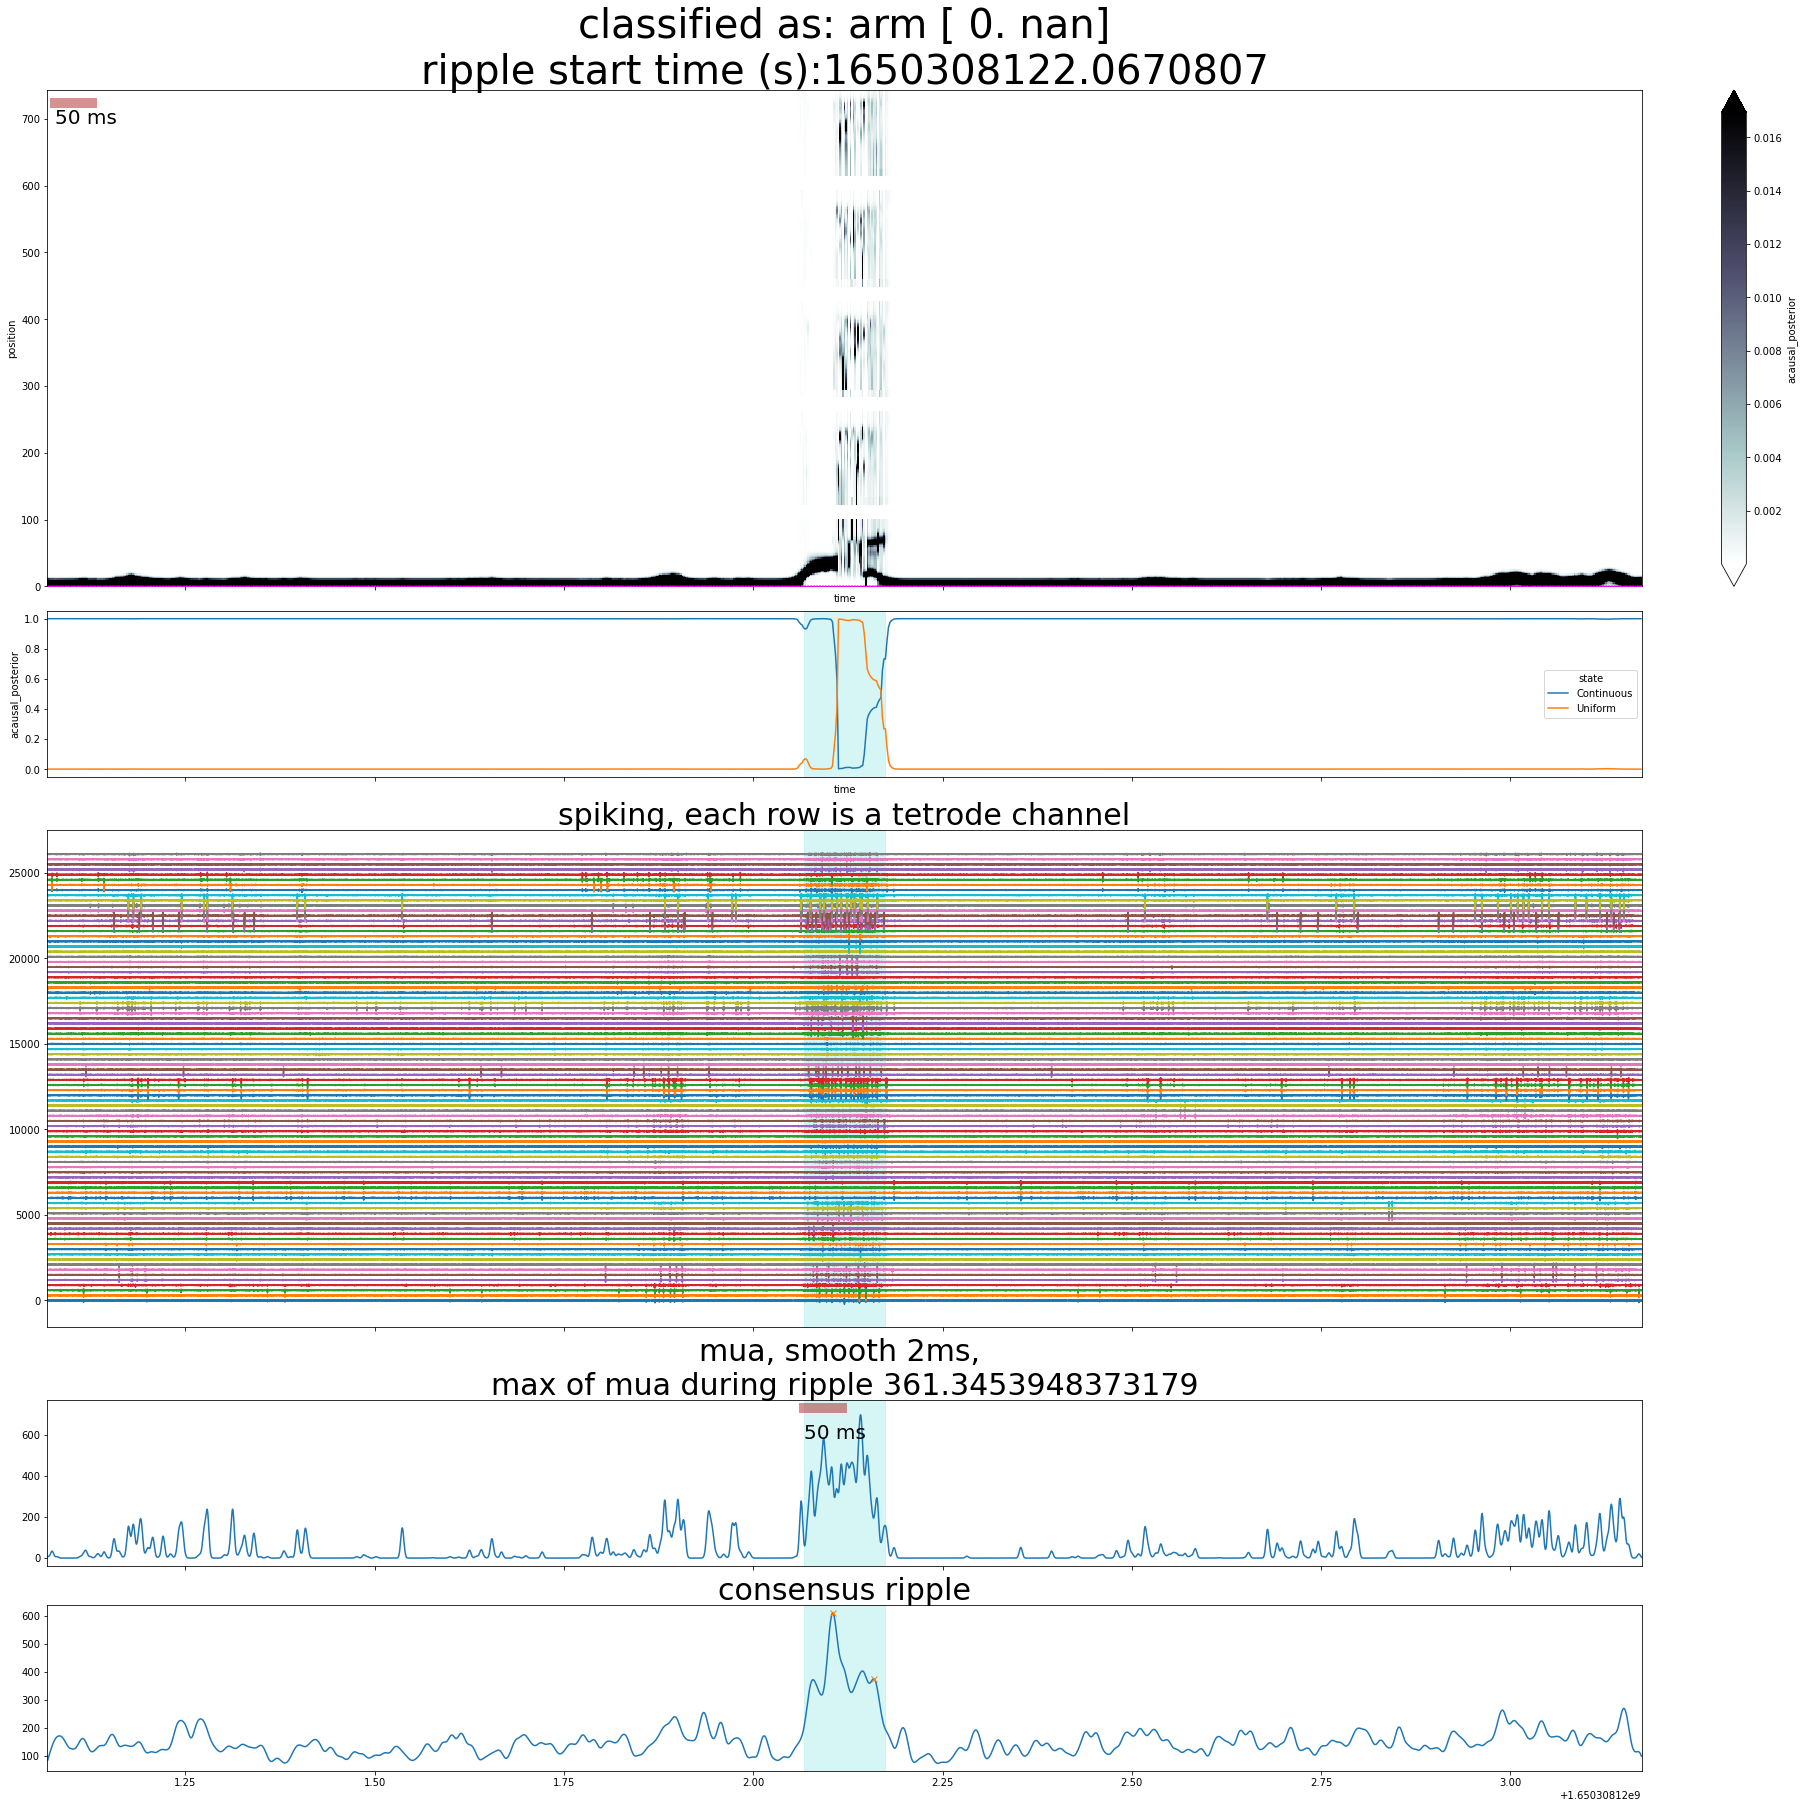

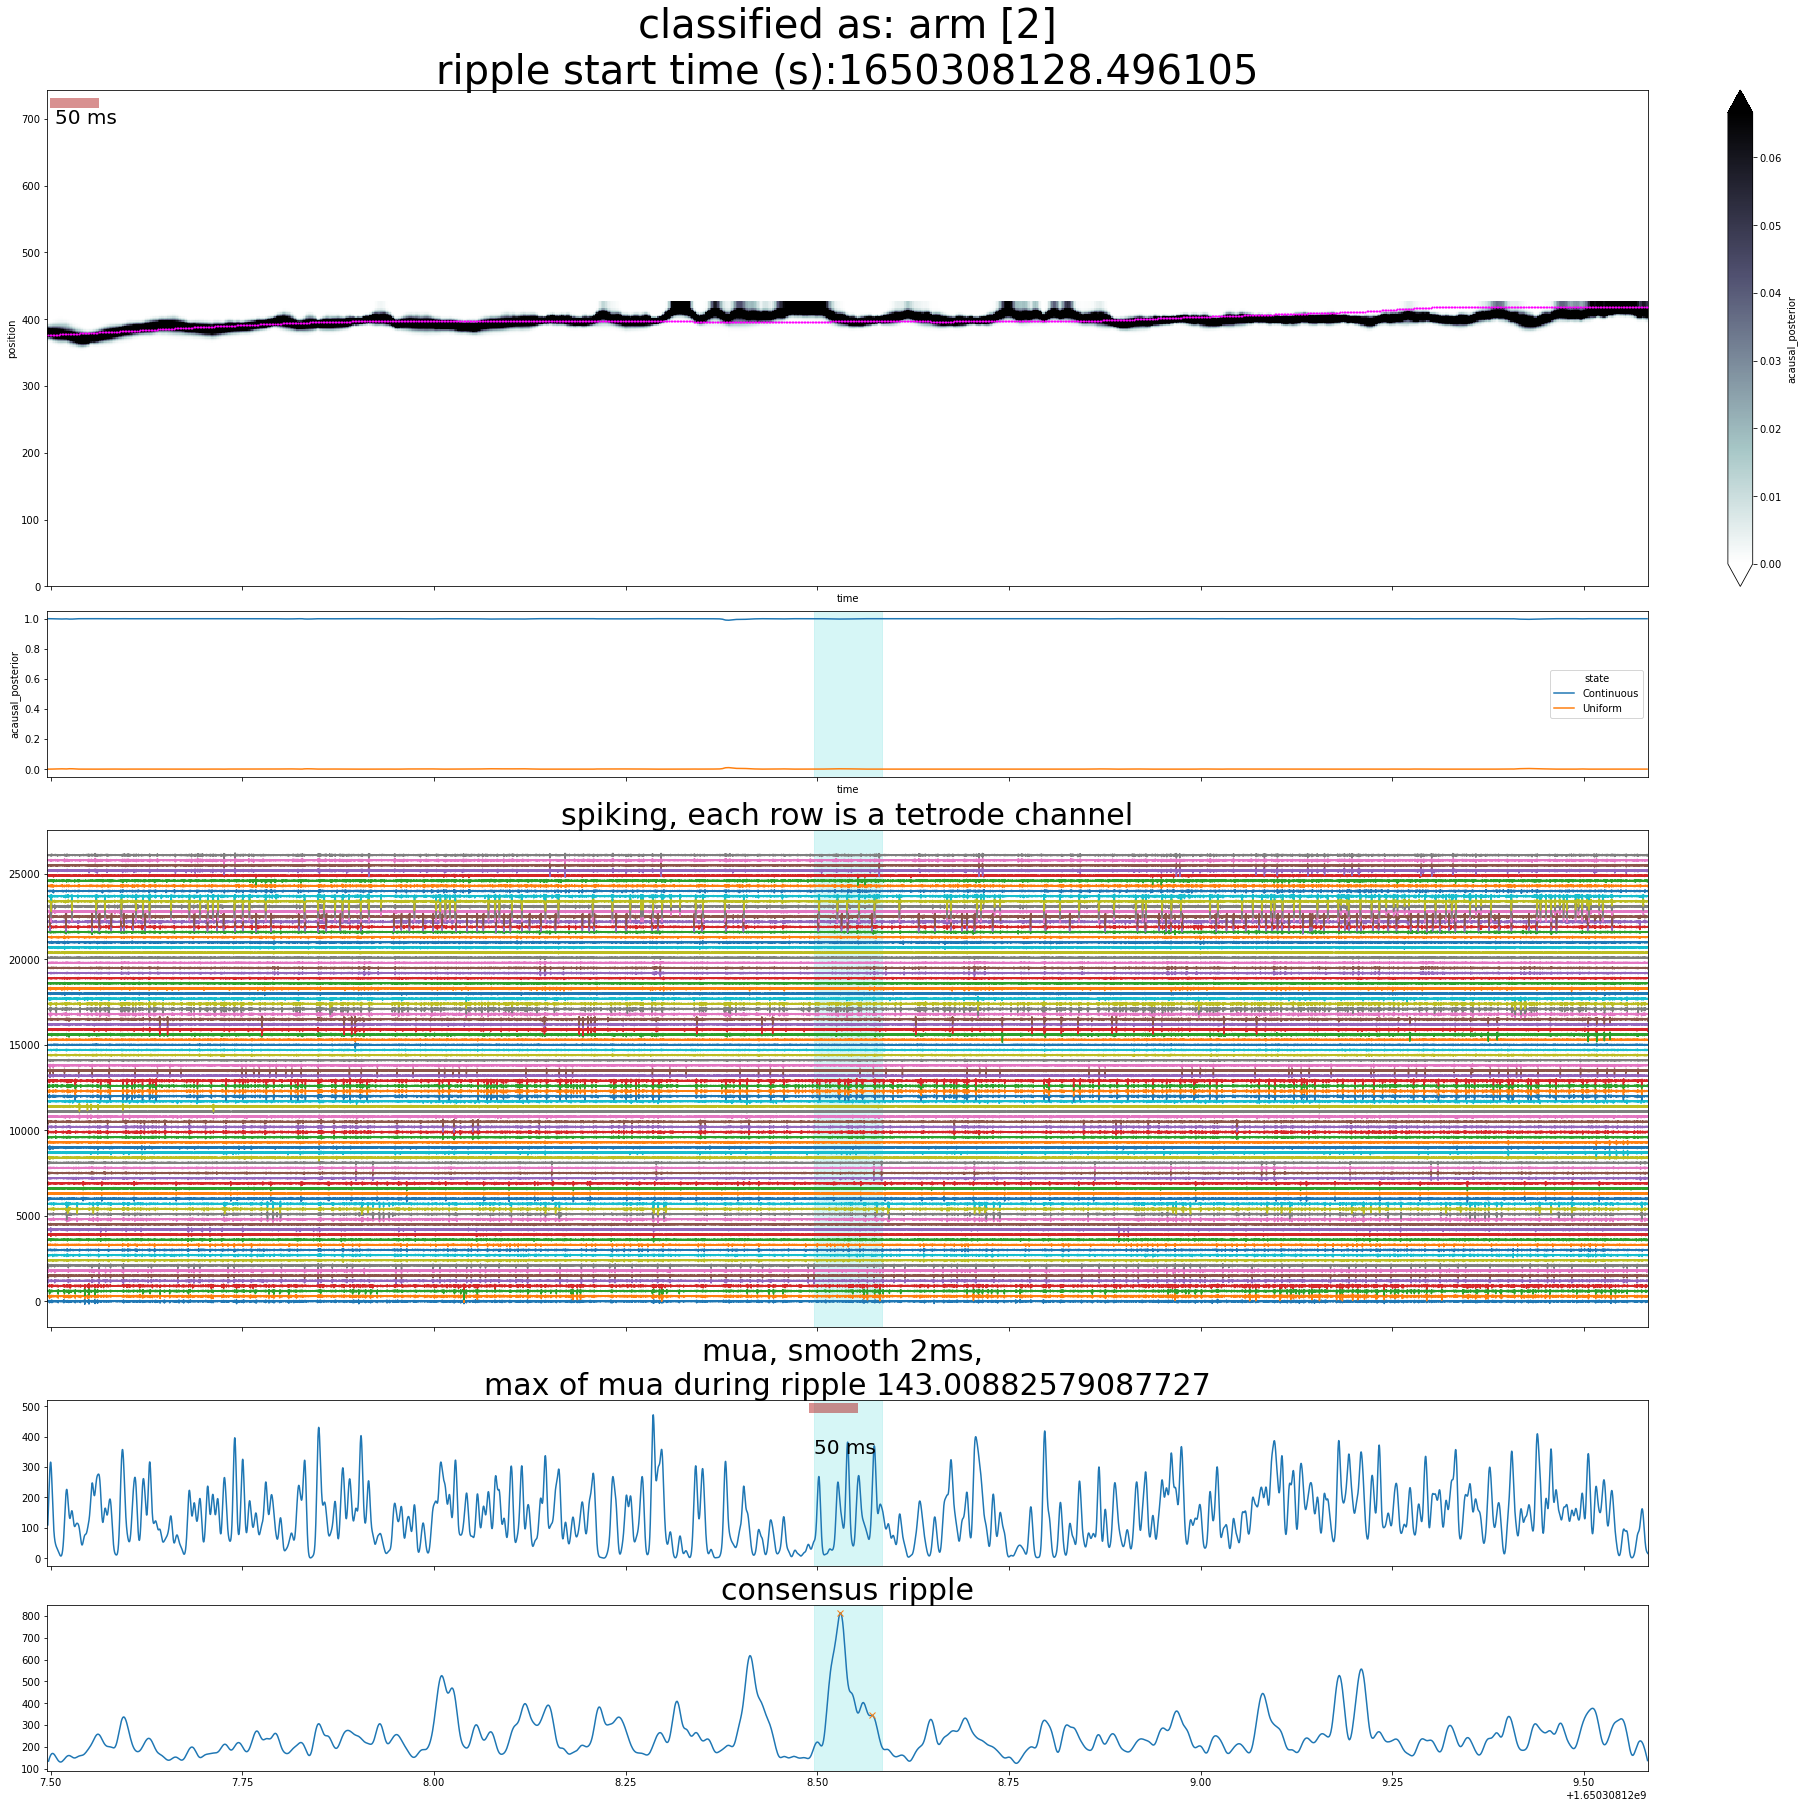

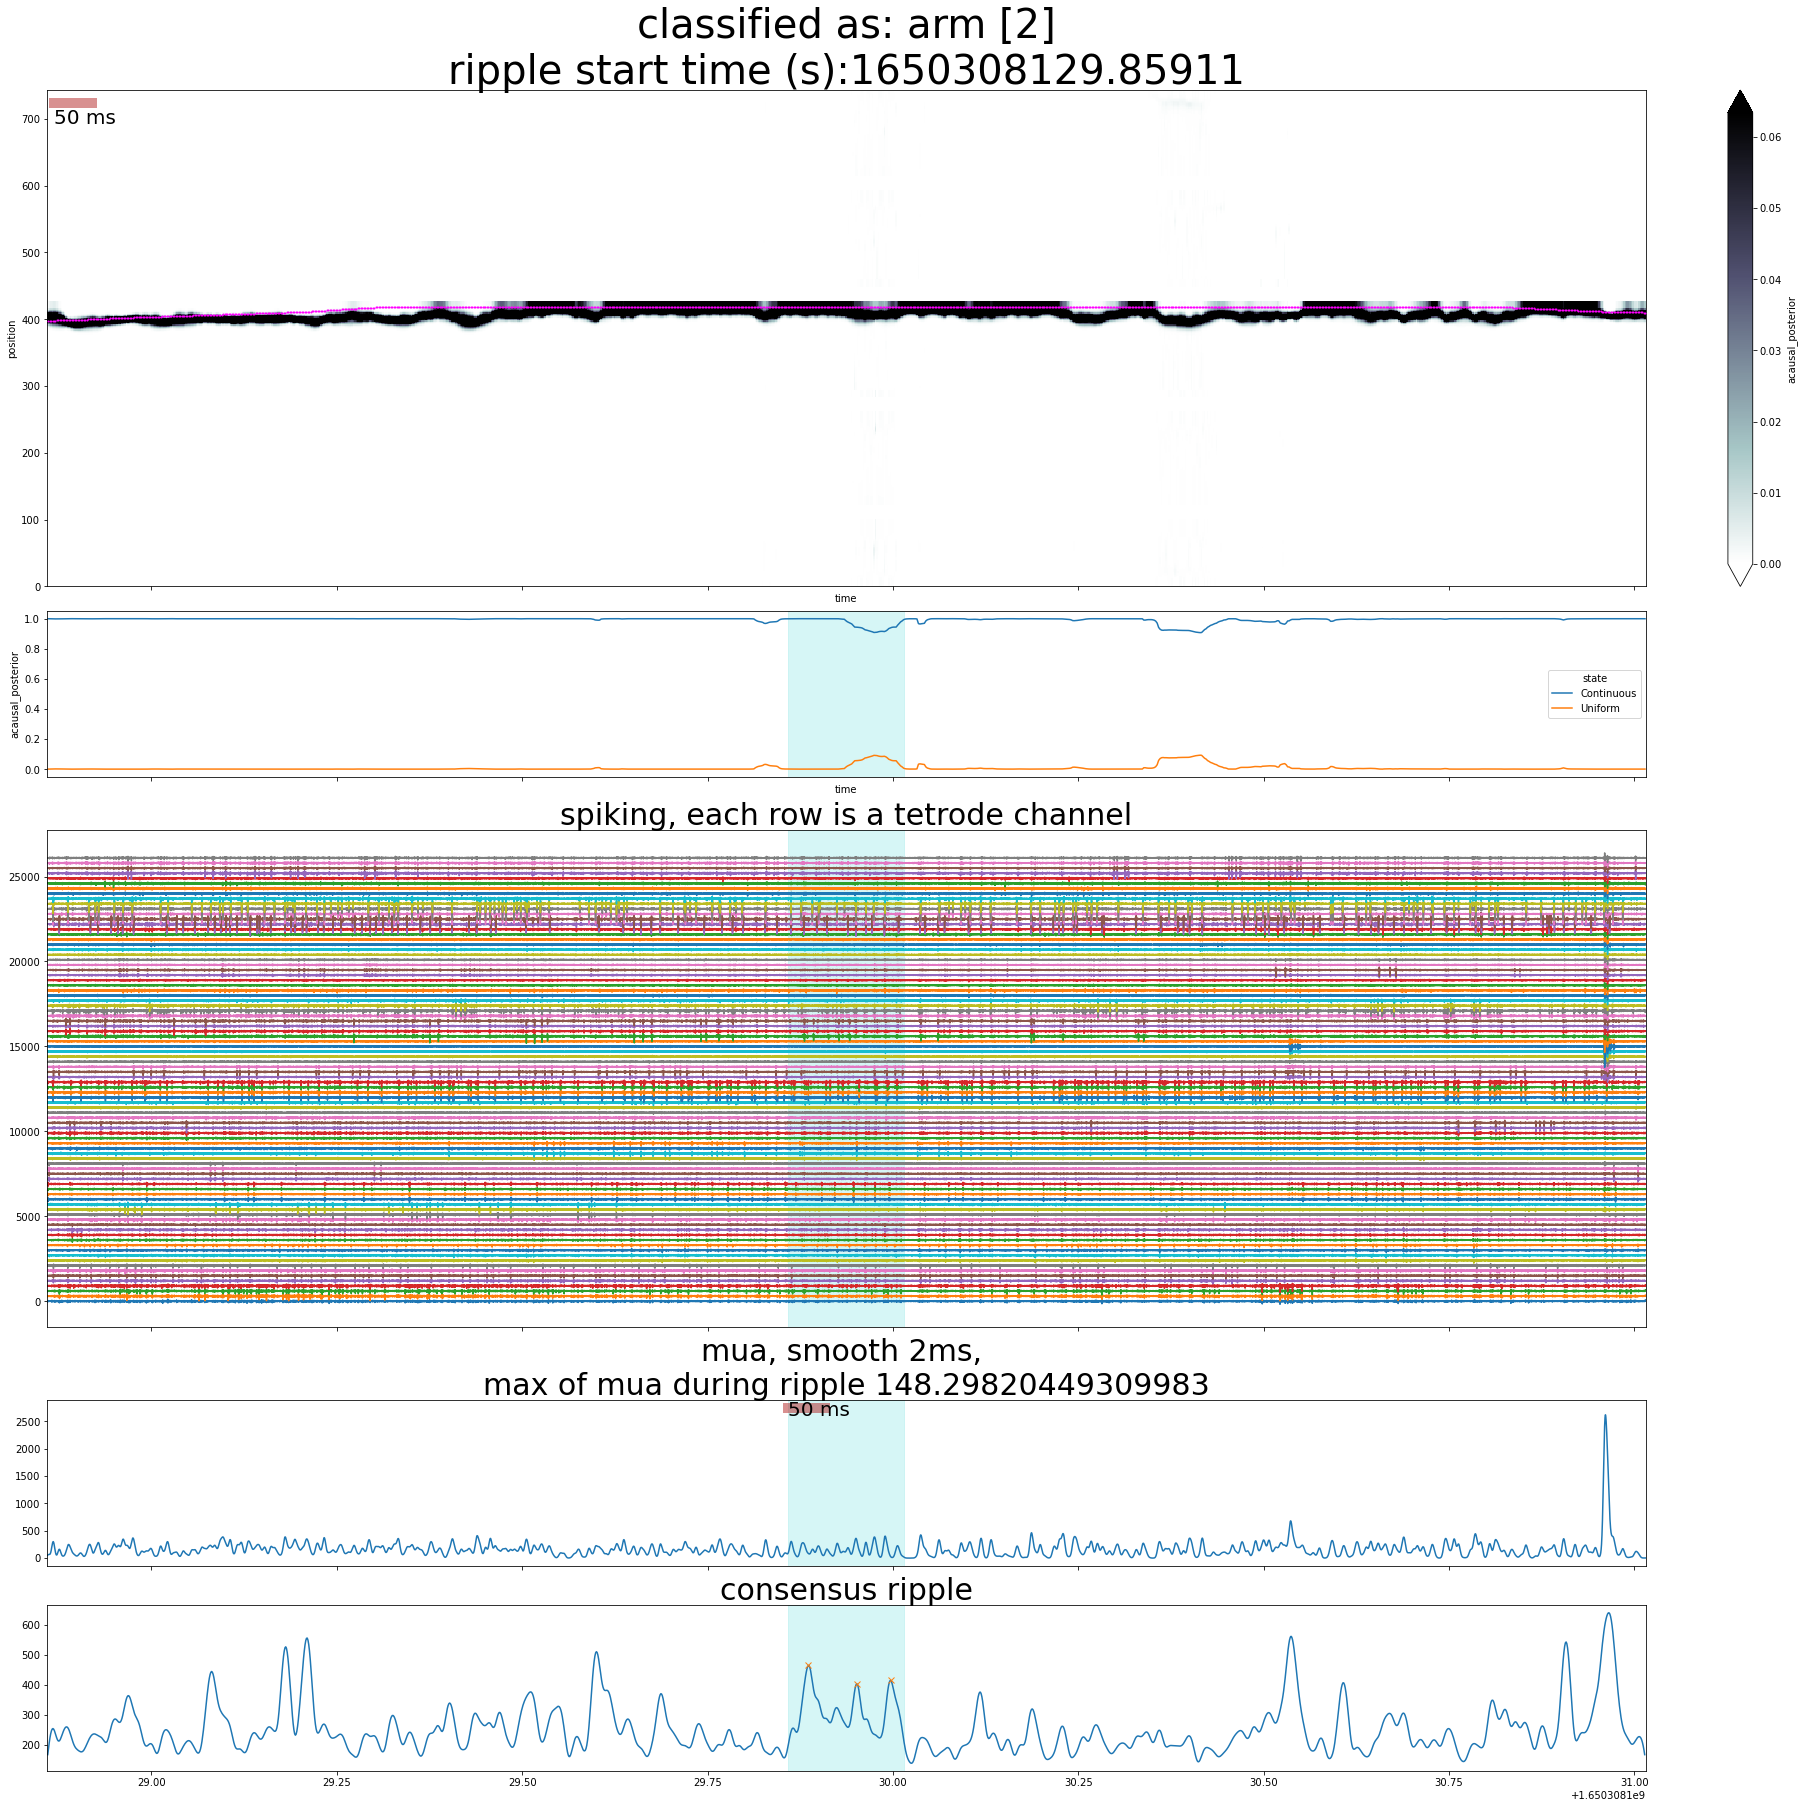

In [115]:
# uncomment the last section in the above cell
ripple_H,replay_H,peak_H,ripple_O,replay_O,peak_O=find_ripple_classify_decode(20)

In [30]:
mua_threshold=np.mean(mua)
mua_threshold

103.14446443798306

### all trials

In [103]:
numWorker=30
print('num of worker:',numWorker)
with multiprocessing.Pool(numWorker) as p:
    results=p.map(find_ripple_classify_decode,legal_trials)

num of worker: 30
103.14446443798306
103.14446443798306103.14446443798306103.14446443798306103.14446443798306103.14446443798306

103.14446443798306
103.14446443798306

103.14446443798306103.14446443798306

103.14446443798306

103.14446443798306103.14446443798306103.14446443798306103.14446443798306103.14446443798306103.14446443798306103.14446443798306
103.14446443798306

103.14446443798306


103.14446443798306103.14446443798306
103.14446443798306





103.14446443798306103.14446443798306103.14446443798306103.14446443798306
103.14446443798306103.14446443798306103.14446443798306


103.14446443798306



[0.9963321089744568, 0.0005938186659477651, 0.0006076196441426873, 0.0005965312011539936, 0.0006348529714159667, 0.001235119765624404]
[0.9772823452949524, 0.003486721543595195, 0.003269072389230132, 0.0042370883747935295, 0.0037787395995110273, 0.007946096127852798]
[0.0002934010117314756, 0.00044258125126361847, 0.0005727284005843103, 0.00048617852735333145, 0.9968107342720032, 0.00139444

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fcecc98d9a0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fccc7cbf760>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/connection.py:341: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fcecc98d9a0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fccc7cbf760>
  self.pid = os.fork()
/home/shijiegu/anaconda3

In [76]:
len(results)

77

In [81]:
for i in range(len(legal_trials)):
    t=legal_trials[i]
    # add to the choice_reward_replay
    log_df_replay.at[t, 'ripple_H']=results[i][0]
    log_df_replay.at[t, 'ripple_O']=results[i][3]
    
    log_df_replay.at[t, 'replay_H']= results[i][1]
    log_df_replay.at[t, 'replay_O']= results[i][4]
    
    log_df_replay.at[t, 'ripple_peak_H']= results[i][2]
    log_df_replay.at[t, 'ripple_peak_O']= results[i][5]
log_df_replay_subset=log_df_replay.loc[legal_trials,:].copy()

In [82]:
pd.set_option("display.max_rows", None)

In [83]:
log_df_replay

,timestamp_H,Home,timestamp_O,OuterWellIndex,rewardNum,ripple_H,ripple_O,replay_H,ripple_peak_H,replay_O,ripple_peak_O
1,1.650477e+09,1.0,1.650478e+09,3.0,2.0,[],"[[[1650477531.8611403, 1650477531.9131403]], [...",[],[],"[[3], [3]]","[[(1650477531.8925874, 338.3577987870237)], [(..."
2,1.650478e+09,1.0,1.650478e+09,4.0,2.0,"[[[1650477537.9771376, 1650477538.0331376]]]","[[[1650477549.1651325, 1650477549.2551327], [1...",[[0]],"[[(1650477537.993605, 408.3638083865905)]]","[[5.0, nan], [4], [4]]","[[(1650477549.177637, 613.449264405786), (1650..."
3,1.650478e+09,1.0,1.650478e+09,2.0,2.0,"[[[1650477586.9751158, 1650477587.0231159]]]",[],[[0]],"[[(1650477587.011746, 345.94219170260226)]]",[],[]
4,NaN,NaN,1.650478e+09,1.0,0.0,[],[],[],[],[],[]
5,1.650478e+09,1.0,1.650478e+09,3.0,1.0,"[[[1650477586.9751158, 1650477587.0231159]]]",[],[[0]],"[[(1650477587.011746, 345.94219170260226)]]",[],[]
6,1.650478e+09,1.0,1.650478e+09,4.0,1.0,[],[],[],[],[],[]
7,1.650478e+09,1.0,1.650478e+09,2.0,1.0,[],"[[[1650477620.6451008, 1650477620.7111008]], [...",[],[],"[[2], [2], [2], [2]]","[[(1650477620.6808426, 700.0328563717563)], [(..."
8,1.650478e+09,1.0,1.650478e+09,1.0,2.0,"[[[1650477636.4370937, 1650477636.507094]], [[...","[[[1650477644.5470903, 1650477644.5910902]], [...","[[0], [0]]","[[(1650477636.4868882, 371.2142238654117)], [(...","[[1], [5, 1], [nan, 1.0], [1]]","[[(1650477644.5579114, 406.2573076265829)], [(..."
9,1.650478e+09,1.0,1.650478e+09,4.0,1.0,[],"[[[1650477668.2010796, 1650477668.2450798]]]",[],[],[[4]],"[[(1650477668.2159793, 522.3150390329575)]]"
10,1.650478e+09,1.0,1.650478e+09,3.0,2.0,[],"[[[1650477682.7110732, 1650477682.7730732]], [...",[],[],"[[3], [3], [3], [3], [3]]","[[(1650477682.723021, 474.246771206721)], [(16..."


In [106]:
# insert into Spyglass
key={'nwb_file_name':nwb_copy_file_name,'epoch':epoch_num,'choice_reward_replay':log_df_replay_subset.to_dict()}
TrialChoiceReplay().make(key,replace=True)

In [14]:
TrialChoiceReplay()

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),"epoch_name session name, get from IntervalList","choice_reward_replay pandas dataframe, choice, reward, ripple time, replays"
molly20220418_.nwb,6,06_Seq2Session3,=BLOB=
molly20220420_.nwb,4,04_Seq2Session2,=BLOB=


## investigate short ripples

In [99]:
short_ripple_H=[]
for i in range(len(legal_trials)):
    t=trial_ind[i]
    ripple_H=log_df_replay.loc[t, 'ripple_H']
    for ri in range(len(ripple_H)):
        if len(ripple_H[ri])==0: #state time is short
            continue
        ripple_=np.reshape(ripple_H[ri],(1,-1))
        if (ripple_[0,-1]-ripple_[0,0])<=0.05:
            short_ripple_H.append((t,ri+1))

In [43]:
replay_ripple_count=np.zeros((10,5))
replay_ripple=np.zeros((10,5),dtype=np.object)
for i in range(len(trial_ind)):
    t=trial_ind[i]
    replay_all=log_df_replay.loc[t,'replay_O']
    ripple_all=log_df_replay.loc[t,'ripple_peak_O']
    
    for ri in range(len(replay_all)):
        replay=replay_all[ri]
        unique_arms=np.unique(np.setdiff1d(replay,[5]))
        replay_arm_num=len(unique_arms)
    
        ripple_num=len(ripple_all[ri])
        if ripple_num<=10 and replay_arm_num<=5:
            replay_ripple_count[ripple_num-1,replay_arm_num-1]+=1
            if type(replay_ripple[ripple_num-1,replay_arm_num-1])=='list':
                replay_ripple[ripple_num-1,replay_arm_num-1].append(replay)
            else:
                replay_ripple[ripple_num-1,replay_arm_num-1]=replay

/tmp/ipykernel_1448730/1564541742.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  replay_ripple=np.zeros((10,5),dtype=np.object)


In [44]:
replay_ripple[:,2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object)

[Text(0, 2, '3'), Text(0, 3, '2'), Text(0, 4, '1')]

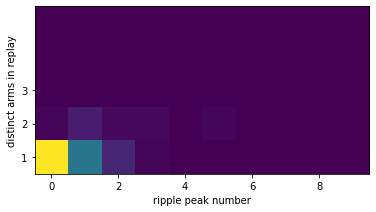

In [45]:
fig, axes = plt.subplots(nrows=1)
plt.imshow(np.flipud(replay_ripple_count.T))
axes.set_xlabel('ripple peak number')
axes.set_ylabel('distinct arms in replay')
axes.set_yticks([2,3,4])
axes.set_yticklabels(['3','2','1'])